## Digit Classification with Nearest Neighbors

### Chris Tralie

Today we talked about <b>supervised learning</b>, which is the process by learning from a set of <b>labeled examples</b>, or examples that have been sorted into different classes beforehand.  We're not always fortunate enough to have data that's labeled like this, but when we do, there are a variety of techniques we can use to learn models of the different classes.  Actually, everything we've done in this class so far can be considered supervised learning, including learning from <a href = "../../Assignments/HW3_Markov">Markov chains trained on text</a> to <a href = "../Week5_BagOfWords">Naive Bayes bag of words</a> and <a href = "../Week6_GradSchoolAdmissions">Gaussian Naive Bayes</a>.  In every application we looked at with these techniques, we <b>trained</b> on our labeled examples and then we tested on some new unseen data that wasn't included in the training set.

In this exercise today, we explore a new supervised learning technique known as <b>nearest neighbors</b>.  If we have a way of measuring a <b>distance</b> between two different data points, then we can apply this technique.  For example, let's suppose we had a labeled set of data points in two classes: red circles and blue squares.  Then, let's say we wanted to guess which of the two classes some new data point was in.  We'll depict this data point as a black triangle, as shown below

<img src = "NN2Dexample.svg">


The <b>K-nearest neighbors</b> technique simply finds the <b>K</b> closest labeled examples, as measured by the distance, and uses them to vote on the class identity of this new point.  In the above example, we choose <b>K = 5</b> for the 5 nearest neighbors, and we happen to get 4 votes for a red circle and 1 vote for a blue square, so we would label this new data point as a red circle.

Overall, we can think of nearest neighbors as a supervised learning technique that <b>memorizes</b> examples.  This means it's only as good as the examples, and it will do better with a higher number and variety of examples, which we don't always have access to.  By contrast, other learning techniques will try to better <b>generalize</b> some knowledge to new examples.  But we'll start with this "memorizer" first.

As simple as this technique may seem, it can work very well in practice.  Below we'll show k-nearest neighbors on an example of 28x28 images of drawn digits, where the labeled examples are obtained from the <a href = "https://en.wikipedia.org/wiki/MNIST_database">MNIST database</a>.  In this case, there are 10 unique classes for the digits between 0 and 9, inclusive. Let's first load in our imports and load in all of the MNIST digits.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.io
import scipy.stats
from skimage.transform import resize
from PIL import ImageTk, Image, ImageDraw
import PIL
from tkinter import *

In [5]:
# Load in all digits
res = 28
digits = []
for i in range(10):
    digits.append([])
    I = skimage.io.imread("Digits/{}.png".format(i))/255.0
    row = 0
    col = 0
    while row < I.shape[0]:
        col = 0
        while col < I.shape[1]:
            img = I[row:row+res, col:col+res]
            if np.sum(img) > 0:
                digits[i].append(img)
            col += res
        row += res
    #print(len(digits[i]), "unique ", i, " digits")

The digits are setup in a 2D array so that <code>digits[i][j]</code> gives the $j^{\text{th}}$ example of digit $i$.  Each digit is itself a $28 \times 28$ 2D array of grayscale values between 0 and 1.

Next, let's try to think about how to define a distance between two digit images.  First, let's look at the range of values in a digit.  We'll pick out the first 0 as an example

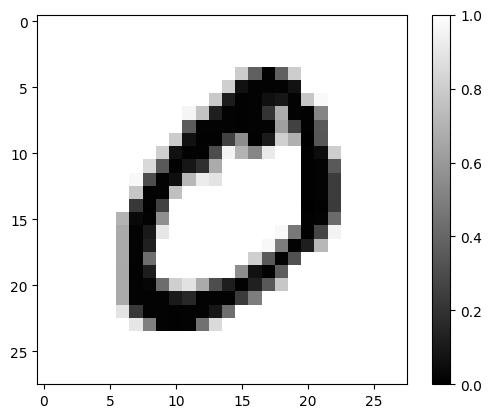

In [3]:
plt.imshow(digits[0][0], cmap='gray')
plt.colorbar()

In this case, we'll compute the <b>Euclidean distance</b> between digits, which is defined as 

### $\sqrt{\sum_{i, j} (X[i, j] - Y[i, j])^2}$

and use this to find the top K nearest digits to a digit that you draw

We'll setup a little interactive canvas where we can draw digits and retrieve their K nearest neighbors.  We'll use <code><a href = "https://numpy.org/doc/stable/reference/generated/numpy.argsort.html">np.argsort</a></code> to help us find the nearest neighbors.  Try it out for yourself!

/var/folders/w9/gq97324j7bs80p9fwh67wvdr0000gn/T/ipykernel_95645/1594049780.py:43: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  guess = scipy.stats.mode([g for (g, _) in guesses])


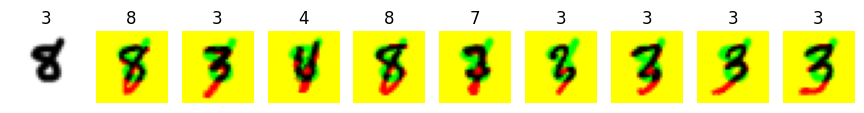

In [12]:
width = 200  # canvas width
height = 200 # canvas height
center = height//2

K = 10 # Number of nearest neighbors to consider

def classify():
    I = np.array(digit_image) # The image that we drew
    I = I[:, :, 0]
    dim = digits[0][0].shape[0]
    I = resize(I, (dim, dim), anti_aliasing=True)
    
    res = 3
    plt.figure(figsize=(12, 6))
    plot_num = 2
    
    ########################################################
    ## TODO: Find k nearest neighbors by looping through all digit examples
    offset = 1
    
    dists = [] # Store a list of distances
    idxs = [] # That's parallel with a list of tuples of (digit #, example index)
    
    ## loop through all the examples
    for i in range(10):
        for j in range(len(digits[i])):
            dists.append(np.sum((digits[i][j]-I)**2))
            idxs.append((i, j))
    
    closets_idxs = np.argsort(dists)[0:K]
    
    guesses = [] # Fill in the array of guesses.  This should be the elements in idxs 
    # with the top K smallest distances
    
    for i in range(K):
        guesses.append(idxs[closets_idxs[i]])
    
    
    ########################################################

    
    ## Plot the guesses
    guess = scipy.stats.mode([g for (g, _) in guesses])
    for k, (num, idx) in enumerate(guesses):
        digit = digits[num][idx]
        plt.subplot(1, K+1, k+1)
        J = np.zeros((I.shape[0], I.shape[1], 3))
        J[:, :, 0] = I
        J[:, :, 1] = digit
        plt.imshow(J)
        plt.title("{}".format(num))
        plt.axis("off")
        plot_num += 1
    plt.subplot(1, K+1, offset)
    plt.imshow(I, cmap='gray')
    plt.axis("off")
        
    root.destroy()

def paint(event):
    """
    Paint on the PIL canvas and the Tkinter canvas in parallel
    Draw canvas will be saved, while Tkinter canvas shows
    the user what they are drawing
    """
    bs = 10
    x1, y1 = (event.x - bs), (event.y - bs)
    x2, y2 = (event.x + bs), (event.y + bs)
    canvas.create_oval(x1, y1, x2, y2, fill="black")
    draw.ellipse([x1, y1, x2, y2], fill="#000000")

root = Tk()

# create a tkinter canvas to draw on
canvas = Canvas(root, width=width, height=height, bg='white')
canvas.pack()

# Create a PIL image and a drawer object
digit_image = PIL.Image.new("RGB", (width, height), (255, 255, 255))
draw = ImageDraw.Draw(digit_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# add a button to save the image
button=Button(text="classify",command=classify)
button.pack()

root.mainloop()

It's worth noting that the above approach is a brute force nearest neighbors approach that uses sorting.  There are tons of ways to improve this.  One of them is to use a data structure known as a <a href = "https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.KDTree.query.html#scipy.spatial.KDTree.query">KD Tree</a>, which is able to hone in on the region of the space that contains nearest neighbors much more quickly without checking every example.  It is roughly analagous to <a href = "https://ursinus-cs371-s2021.github.io/Modules/Module8/Exercise0">binary search</a> performed spatially.  Sadly, KD Trees to suffer from what's known as the "curse of dimensionality."  Therefore, one often uses an <a href = "https://github.com/spotify/annoy">approximate nearest neighbors</a> scheme.